In [1]:
# 导入库和加载数据
import torch    # 负责张量,CPU/GPU运算,自动求导(autograd),基础数学运算
import torch.nn as nn   # 负责定义神经网络结构(Linear,Conv,RNN,......),以及损失函数，管理模型参数等
import torch.optim as optim     # 梯度算完了，那w怎么变?它管的是用什么策略更新参数
from torchvision import datasets,transforms    # 专门为视觉任务准备的库,
from torch.utils.data import DataLoader     # 负责划分batch,shuffle以及拼接batch


# 读取图像数据
transform = transforms.Compose([
    transforms.ToTensor(),  # 将加载的图像数据从PIL图像或NumPy ndarray转换成PyTorch的张量（Tensor）
                            # 具体来说，它把图片的格式从 (Height, Width, Channel) 变为 (Channel, Height, Width)，符合PyTorch对输入数据的通道优先格式要求。
                            # 同时，将像素值从整数范围 [0, 255] 归一化到 [0.0, 1.0] 浮点数区间。
])
"""
理由：
PyTorch的神经网络模块接受的数据必须是Tensor格式，且通常是浮点数，用于方便梯度计算和数值稳定。
网络训练时使用归一化后的浮点数输入，保证数值尺度统一，有助于反向传播和优化过程稳定。
"""


# 加载cifar_10数据集的训练集
train_dataset = datasets.CIFAR10(
    root = "./data",    # 记录文件路径(这里会直接在当前文件夹下存放数据集)
    train = True,   # 加载cifar_10数据集的训练集
    download = True,    # 如果本地没找到数据，则自动下载
    transform = transform   # 这个transform就是上面的那个transform，是一个函数对象
)


# 加载cifar_10数据集的训练集
test_dataset = datasets.CIFAR10(
    root = './data',
    train = False,  # 让 Dataset 使用“测试集那一部分数据”
    download = True,
    transform=transform
)
"""
CIFAR10是一个继承自Dataset的数据集对象
这个对象里面通常包含：
文件路径
数据索引
标签列表
transform(函数对象)
一些元信息 
"""



# 创建用于训练的数据加载器
train_loader = DataLoader(
    train_dataset,
# 这是数据源。就是我们上一步创建的那个包含了50000张训练图片和标签的 CIFAR10 数据集对象。
# DataLoader 会从这里面取数据。
    
    batch_size = 64,
# 意思是“批次大小为64”

# """
# DataLoader 不会一次性把50000张图片全部加载到内存里（这会撑爆内存），而是每次只取出64张图片及其对应的标签，
# 打包成一个批次。
# 为什么这么做?
# 内存效率：防止内存溢出。
# 训练效率：GPU并行处理64张图片比一张一张处理要快得多。
# 优化稳定性：用一个批次（64张图片）的平均梯度来更新模型参数，比只用一张图片（梯度随机性大）或全部图片（计算成本太高）
# 要更稳定和高效。这就是所谓的小批量梯度下降 (Mini-batch Gradient Descent)。
# """

    shuffle = True,
# 意思是打乱数据
    

# """
# 在每个训练周期（epoch）开始时，DataLoader 会随机打乱整个 train_dataset 的顺序，然后再按顺序取出批次。
# 为什么这么做？（非常重要！）
# 打破数据顺序的依赖：如果数据是按类别排序的（比如先是1000张猫，然后1000张狗……），模型在训练初期会连续看到同一
# 种类的样本，导致梯度更新方向出现偏差，学得不好。
# 提高模型泛化能力：每次训练看到的批次组合都不同，这增加了训练的随机性，能有效防止模型“背诵”训练数据的顺序，
# 从而学习到更通用的特征。这就像你学习时，不按课本章节顺序，而是随机抽查知识点，这样记得更牢。
# """

    num_workers = 2
# 讲串行工作流改为并行工作流，是为了提高GPU的利用率，理想状态就是你拿数据刚好跟的上GPU的计算速度
# 这 2 个 worker 同时并行工作，各自负责从硬盘（或内存）读取数据、做 transform/augmentation、打包成 batch，
# 然后把准备好的 batch 放进一个共享的队列（queue）里。
# 两个 worker 在后台同时在读不同的数据（因为 Dataset 是可索引的，每个 worker 拿到的 index 是不同的，
# 不会重复读同一张图片）。
# 提前准备了多个 batch，主进程几乎不用等 IO/预处理，就能持续拿到数据 → GPU 利用率更高，训练更快。
# 但是如果硬盘带宽不够（比如机械硬盘），反而会因为争抢 IO 而变慢，另外还存在进程切换以及内存爆炸等问题
# 所以 num_workers 需要根据实际情况调整,并不是越大越好
)


# 创建用于测试的数据加载器
test_loader = DataLoader(
    test_dataset,
    batch_size = 64,
    shuffle = False,
# 意思是不打乱数据
# """
# DataLoader 会始终按照固定的顺序来加载测试数据。
# 为什么这么做？
# 评估的确定性：测试的目的是评估模型性能，我们希望每次评估的结果都是一致、可复现的。如果打乱了顺序，
# 虽然最终的准确率不变，但每次运行的中间过程会不同，不利于调试和比较。
# 没有必要：测试时我们不更新模型参数，只是前向传播计算结果，所以数据顺序对模型的最终评估指标（如准确率）没有影响。
# 打乱顺序没有收益，反而失去了结果的可复现性。
# """
    num_workers = 2

)




d:\Anaconda\envs\py312_env\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


img的类型是： <class 'torch.Tensor'>
img的形状是： torch.Size([3, 32, 32])
此时存储在CIFAR10实例中的训练集图像数据的类型是:<class 'numpy.ndarray'>
此时训练集图像数据的形状是：(50000, 32, 32, 3)
数据集中单个图像数据的类型是：<class 'torch.Tensor'>
数据集中单个图像数据的形状是：torch.Size([3, 32, 32])
训练集大小：50000
测试集大小：10000
训练集标签：[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4

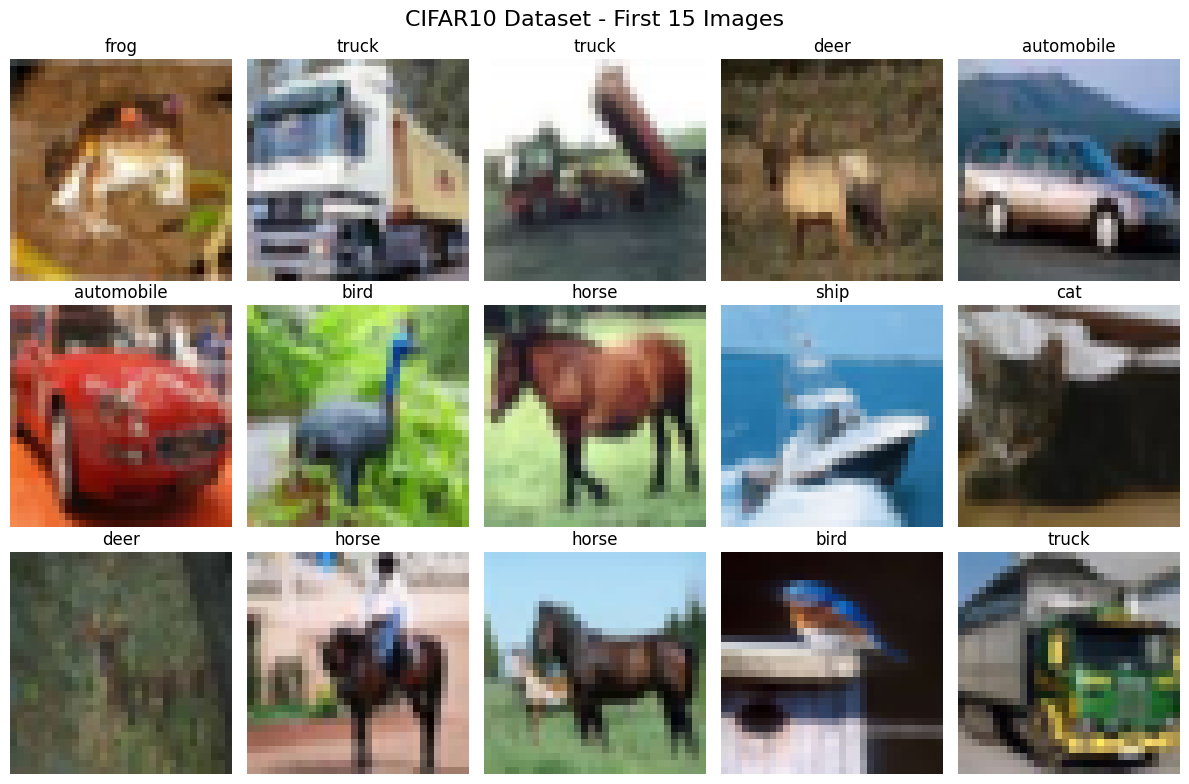

In [ ]:
import matplotlib.pyplot as plt

# 查看你导入的数据图片(在实际搭建模型中不需要这一步)
img,label = train_dataset[0]
print('img的类型是:',type(img))
print('img的形状是:',img.shape)

# 查看你的训练集的图像数数据
print(f'此时存储在CIFAR10实例中的训练集图像数据的类型是:{type(train_dataset.data)}')
print(f'此时训练集图像数据的形状是：{train_dataset.data.shape}')

#实际上，如果你在初始化CIFAR10实例的时候把transform参数设置为None，那么CIFAR10实例中存储的图像数据类型
# 是PIL.Image.Image，而不是Tensor。

# 查看数据集中单个图像数据的信息
print(f'数据集中单个图像数据的类型是：{type(train_dataset[0][0])}')
print(f'数据集中单个图像数据的形状是：{train_dataset[0][0].shape}')


print(f'训练集大小：{len(train_dataset)}')
print(f'测试集大小：{len(test_dataset)}')

# 查看训练集的标签
print(f'训练集标签：{train_dataset.targets}')
print(f'datasets中存储训练集标签的容器是:{type(train_dataset.targets)}')

print('训练集的类别是：',train_dataset.classes)
#在 CIFAR10 这个类的定义里，官方已经提前写死了：self.classes = [
#     'airplane', 'automobile', 'bird', 'cat', 'deer',
#     'dog', 'frog', 'horse', 'ship', 'truck'
# ]





fig,axes = plt.subplots(nrows=3,ncols=5,figsize=(12,8))
# 这一步干了三件事：
# 创建一个 Figure（整张画布）
# 创建一个 3 × 5 的 Axes 网格
# axes 是一个 二维数组:
# axes[0][0]  axes[0][1] ... axes[0][4]
# axes[1][0]  axes[1][1] ... axes[1][4]
# axes[2][0]  axes[2][1] ... axes[2][4]

plt.suptitle('CIFAR10 Dataset - First 15 Images',fontsize=16)
#给整张图加一个总标题,不影响子图


#核心循环：取数据 + 画图
for i in range(15):
    row=i//5
    col=i%5
    img,label = train_dataset[i]
    # axes[row][col].imshow(img.permute(1,2,0).numpy())
    axes[row][col].imshow(img.permute(1,2,0))
#在一些较旧的版本中matplotlib的imshow()函数要求输入的图像是numpy.ndarray类型，但是新版本中已经支持了tensor类型
#另外matplotlib 的 imshow 函数期望的彩色图像数据格式是 (高度, 宽度, 通道)，也就是 (H, W, C)
#所以需要使用 permute 方法将张量的形状从 (C, H, W) 转换为 (H, W, C)
    axes[row][col].set_title(f'{train_dataset.classes[label]}')
    axes[row][col].axis('off')#关闭坐标轴，使图像更整洁。
    
plt.tight_layout()#自动调整子图之间的间距，防止标题、刻度、图片彼此重叠。
plt.show()
    

In [11]:
# 搭建CNN模型
class CNN_CIFAR10(nn.Module):
    def __init__(self,num_classes=10):
        super().__init__()   # 调用父类的初始化写法，这是标准写法

        #特征提取模块
        self.conv_block1=nn.Sequential(
# """
# 这里定义了一个名为 features 的类属性。按照惯例，这个部分通常用来存放模型的特征提取部分，也就是卷积和池化层。
# nn.Sequential(...): 这是一个非常有用的容器。你可以把一系列的网络层按顺序放进 nn.Sequential 中。当数据通过
# 这个容器时，它会自动地、依次地流过你放入的每一个层，你无需在 forward 方法中手动一个一个地调用它们。这让代码
# 结构非常清晰。
# """

            nn.Conv2d(3,32,kernel_size=3,padding=1),
# 第一个参数3其实就是in_channels=3,表示输入的通道数,3表示RGB图像有3个通道
# 第二个参数32是out_channels=32,表示输出的通道数,这个数字可以自己设置,数字越大,模型越复杂,计算量越大
# 但是这个通道数并不是我们说的图像的通道，它其实是说卷积层里有 32 个“卷积神经元 / 卷积核”
# 每个卷积核都会输出 1 张特征图,所以最终输出是 32 张特征图
# 第三个参数3是kernal_size=3,表示卷积核的大小,3表示3x3的卷积核
# 第四个参数padding=1,表示卷积核的填充,1表示在图像的周围填充1圈0,这样可以保持图像的大小不变


# """
# 动作: 一个 3x3 的小窗口（称为卷积核或滤波器）在整个输入图像上滑动。在每个位置，它都会计算窗口内像素与卷积核
# 权重之间的加权和。
# 理论 (局部感受野 & 参数共享):
# 局部感受野: 每个神经元不再连接到所有输入像素，而只连接到这个 3x3 的小区域。这保留了像素的局部空间关系。
# 参数共享: 这是CNN效率的关键。同一个 3x3 的卷积核（包含9个权重）在整张图像上共享使用。如果这个卷积核学会了
# 识别“左上到右下的对角线”，那么它可以在图像的任何位置识别出这个特征，而无需为每个位置都学习一个独立的检测器。
# """
            
            nn.BatchNorm2d(32),

            nn.ReLU(),
# 理论: 如果没有非线性激活函数，多层卷积网络无论多深，其效果都等同于一个单层卷积网络，无法学习复杂的模式。
# ReLU引入了非线性，允许网络学习特征之间更复杂的关系。
# 直观比喻: 这是一个“阈值开关”。只有当手电筒在某个位置发现的模式足够“强烈”（加权和大于0）时，我们才认为这个
# 特征被“激活”了，否则就忽略它。


            nn.MaxPool2d(2),#一个 2x2 的窗口在特征图上滑动，每次只保留这个窗口内的最大值，并丢弃其他值。
            #这使得特征图的尺寸（高和宽）都减半,因为每 2×2 个像素压缩成 1 个像素
# 降维: 大幅减少了下一层需要处理的数据量，降低了计算复杂度，有助于防止过拟合。
# 平移不变性 (Translation Invariance): 它使模型对特征的微小位移不那么敏感。如果一个“眼睛”特征在 2x2 窗口内
# 稍微移动了一下，只要它仍然是这个窗口内的最大值，池化后的输出就不会改变。这使得模型更加鲁棒。
        )

        self.conv_block2=nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,padding=1),
# 注意，这里的输入通道数必须等于上一个卷积块的输出通道数（32）。它现在处理的是那 32 张初级特征图。
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block3=nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        

        #分类模块
        self.classifier = nn.Sequential(
#  定义另一个名为 classifier 的类属性。按照惯例，它用来存放模型的分类部分，通常由全连接层组成。
            nn.Linear(128*4*4,128),  # 定义一个全链接层，或者说一个线性层
# """
# in_features=128* 4 * 4: 这是连接卷积部分和全连接部分的关键。self.features 的输出是 (128, 4, 4) 的特征图。
# 为了将它送入全连接层，我们必须先将其“压扁”成一个一维向量。这个向量的总长度就是 通道数 × 高 × 宽，
# 即 128 * 4 * 4 = 2048。所以，这个全连接层的输入节点数是 2048。
# out_features=128: 将 2048 维的特征向量映射到一个 128 维的中间表示。也就是说隐藏层的神经元有128个
# """
            nn.ReLU(),
            nn.Dropout(0.5),    # # Dropout层：以50%的概率随机丢弃神经元，防止过拟合
            nn.Linear(128,out_features=num_classes)
# in_features=128,输入节点数必须与上一层的输出节点数（128）匹配。
# out_features=10,输出结点数为10，由于CIFAR10数据集有10个类别，因此这里最终输出10个值。
# 这10个值被称为logits，分别代表模型预测输入图像属于这10个类别的原始分数
# logits = 模型在“还没变成概率之前”的原始输出分数.也可以说：logits 是送进 softmax / sigmoid 之前的值

        )


    def forward(self,x):
        x=self.conv_block1(x)
# 因为nn.Sequential这个类里面实现了一个__call__方法，所以x = self.conv_block1(x)实际上就是：
# x = self.conv_block1.__call__(x)，而它内部又实现了一个forward方法，所以它又会调用
# self.conv_block1.forward(x)
        """
        而nn.Sequential这个类里面实现的forward方法的大概逻辑就是：
        def forward(self, x):
            for layer in self:
                x = layer(x)
            return x
        就是说接收一个参数，然后把它依次传递给我内部的所有子模块。”
        """

        x=self.conv_block2(x)
        x=self.conv_block3(x)


        x=x.view(x.size(0),-1)  # x.size(0)就是批大小，-1是一个占位符，意思是把剩下所有维度都乘起来
                                # 这里就是 64 * 8 * 8 = 4096
                                # 所以,view 操作把(64, 64, 8, 8)的四维Tensor压成了一个(64, 4096)的二维Tensor

        x=self.classifier(x)    # 这里执行完后最终就变成了(64,10)的Tensor
        return x                # 这个返回的Tensor将会被送到损失函数里，与真实标签及逆行比较
                                # 从而计算损失进行反向传播

In [13]:
# 实例化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_CIFAR10().to(device)
# nn.module已经实现了to方法，它会递归地把模块里的所有参数和buffer移动到指定

print(type(model))
print(f"Using device: {device}")
"""
model此时已经:
拥有完整的网络结构
拥有所有可训练参数(weights / bias)
已经被 .to(device) 放到了 CPU 或 GPU 上
但是此时的参数是随机初始化的，因为还没有训练过
"""

<class '__main__.CNN_CIFAR10'>
Using device: cpu


'\nmodel此时已经:\n拥有完整的网络结构\n拥有所有可训练参数(weights / bias)\n已经被 .to(device) 放到了 CPU 或 GPU 上\n但是此时的参数是随机初始化的，因为还没有训练过\n'

In [7]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
# model.parameters() 会自动收集你在 __init__ 中定义的所有层（nn.Conv2d, nn.Linear等）中需要被训练的参数。
# 优化器拿到这个参数列表后，就知道自己要“更新”哪些数字了。

# lr 代表 Learning Rate（学习率）

In [ ]:
# 训练逻辑
from tqdm import tqdm

def train_epoch(model,loader):
    model.train()   # 切换到训练模式

# """
# 理由: 模型中的某些层在训练和测试时的行为是不同的。最典型的两个是 Dropout 和 Batch Normalization。
# Dropout 层在训练时会随机“丢弃”一些神经元，以防止过拟合；但在测试时，它必须使用全部的神经元来进行最准确的预测。
# Batch Normalization 层在训练时会计算当前批次的均值和方差来归一化数据；但在测试时，它会使用在整个训练过程中
# 学到的固定的均值和方差。
# 调用 model.train() 就是为了确保这些层处于正确的“训练”行为模式。与之对应的是 model.eval()，用于测试阶段。
# """


    # 初始化统计变量
    total_loss=0
    total_correct=0
    total_samples=0
# """
# 作用: 创建变量来记录整个 epoch 的总损失、总正确数和总样本数。
# 理由: 我们是分批次(batch by batch)进行训练的，每一批次的损失和准确率都会有波动。我们关心的是整个 
# epoch 的平均表现，而不是某一个批次的表现。因此，需要这些变量来累加每一批次的结果，以便最后计算总的平均值。
# """



    #for i,(images,labels) in enumerate(tqdm(loader,desc='Training',leave=False)): # 这里enumerate和tqdm不会冲突，但是它两的顺序不能颠倒
    for i, (images, labels) in enumerate(loader):
         #dataloader会帮你把image和label转换成Tensor，而张量是有to方法的
        images,labels = images.to(device),labels.to(device)

         #前向
        outputs = model(images) # 注意nn.module重载了__call__函数
        loss = criterion(outputs, labels)
        #print(f'loss的类型是:{type(loss)}')
# """
# __call__内部的大致逻辑就是:
# def __call__(self, *args, **kwargs):
#     return self.forward(*args, **kwargs)
# 所以
# model(images)
# ↓等价于
# model.forward(images)

# __call__ 里还做了很多事：
# autograd 记录
# forward hook
# train() / eval() 行为
# 所以：你永远不需要直接手动调用 forward()
# 
# 同理，nn.CrossEntropyLoss 也重载（准确说：继承）了 __call__ 方法
# 所以loss = criterion(outputs, labels)的真实调用顺序就是：
# criterion.__call__(outputs, labels)
#         ↓
# criterion.forward(outputs, labels)
#         ↓
# 返回 loss tensor
# 
# 它的forward大致上就是说：
# def forward(self, logits, target):
#     log_probs = log_softmax(logits)
#     loss = nll_loss(log_probs, target)
#     return loss
# """

        #反向
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

         #统计
        _,predicted = torch.max(outputs,dim=1)
# """
# torch.max 会返回一个元组 (values, indices)。
# values: 每一行的最大分数值是多少。例如 tensor([2.5, 3.1, ...])。我们通常不关心具体分数，只关心谁是第一名。
# indices: 每一行最大分数值所在的索引。例如 tensor([1, 5, 2, ...])。这个索引恰好就是模型预测的类别标签！
# _, predicted: 我们用 _ (一个通用的占位符) 来接收我们不关心的 values，用 predicted 变量来接收我们真正需要的 indices。
# 结果: predicted 是一个形状为 [64] 的 Tensor，包含了模型对这64张图片的最终预测结果。
# """


        total_correct += (predicted==labels).sum().item()
# """
# 这是一行非常优雅的“链式操作”，我们把它拆开看：
# (predicted == labels):
# predicted 是 tensor([1, 5, 2, ...])。
# labels 是 tensor([1, 4, 2, ...])。
# PyTorch会逐个元素进行比较,返回一个布尔(Boolean)类型的 Tensor:tensor([True, False, True, ...])。
# True 代表预测正确,False 代表预测错误。

# .sum():
# 对一个布尔 Tensor 求和时,True 会被当作 1,False 会被当作 0。
# 所以，.sum() 的结果就是这个批次里 True 的总数，也就是答对题目的数量。结果是一个只包含一个元素的 Tensor,
# 例如 tensor(58)。

# .item():
# tensor(58) 仍然是一个 PyTorch Tensor,它带着设备信息(CPU/GPU)和计算图历史。
# .item() 方法的作用是，从一个只包含单个数值的 Tensor 中，提取出那个数值本身，并将其转换为一个标准的 Python 
# 数字（例如，整数 58）。
# 为什么要这么做？ 这是为了性能和内存管理。我们只想累加一个纯粹的数字，不需要保留它的计算图历史。
# 如果不加 .item()，每次累加都会增加计算图的长度，可能导致内存溢出。

# 结果: total_correct 这个 Python 变量的值增加了本批次答对的数量。
# """
        total_samples += labels.size(0)
# """
# 目标: 累加我们已经处理过的样本总数。
# 动作: labels.size(0) 获取 labels 这个 Tensor 第0个维度的大小。因为 labels 的形状是 [64],
# 所以 labels.size(0) 就是 64,即批次大小。
# 为什么不直接 += 64? 因为最后一个批次可能不足64个!例如,总共1000个样本,batch_size=64,最后一个批次
# 只有 1000 % 64 = 40 个样本。用 labels.size(0) 可以精确地处理这种情况。
# 结果: total_samples 记录了到目前为止已经训练了多少张图片。
# """

        total_loss += loss.item()
# """
# loss 是我们之前通过 criterion(outputs, labels) 计算得到的，它是一个单元素的 Tensor，例如 tensor(0.2345)。
# 同样，我们使用 .item() 将其转换为一个纯粹的 Python 浮点数 0.2345。
# 将其累加到 total_loss 上。

# 结果: total_loss 累加了所有已处理批次的损失值之和。
# """


        # 每100个批次打印一次训练信息
        if (i+1) % 100 == 0:
            print(f'  Loss: {loss.item():.4f}')


    accuracy = total_correct / total_samples
# """
# 目标: 计算整个 Epoch 的总准确率。
# 动作: 这是最经典的准确率公式：总答对数 / 总题目数。
# 结果: accuracy 是一个 0 到 1 之间的浮点数，代表模型在整个训练集上学习一遍后的表现。
# """

    avg_loss = total_loss / len(loader)
# """
# 目标: 计算整个 Epoch 的平均损失。

# 动作:
# total_loss 是所有批次损失值的总和。
# len(loader) 是 DataLoader 将会产生的总批次数。
# 为什么除以批次数，而不是总样本数？ 因为我们之前计算的 loss 通常是一个批次的平均损失
# (CrossEntropyLoss 默认 reduction='mean'）。所以 total_loss 是“批次平均损失”的总和。
# 为了得到整个 Epoch 的“平均批次损失”，我们应该除以总批次数。这是一种标准且通用的做法。

# DataLoader 在 PyTorch 里被设计成“一个 batch 生成器”，
# 所以它的长度定义为：能生成多少个 batch。

# 结果: avg_loss 代表在这个 Epoch 中，模型在处理每一个批次时，平均“错得有多离谱”。
# """

    return avg_loss, accuracy

In [9]:
# 评估在验证集或训练集上的预测准确率

def evaluate(model,loader): # laoder就是一个DataLoader对象
    model.eval()

    total_correct=0
    total_samples=0

    with torch.no_grad():
# """
# 一个对象只要告诉 Python 它有__enter__和__exit__ 这两个方法，就可以成为一个上下文管理器
# 而torch.no_grad() 就是一个精心设计的上下文管理器
# orch.no_grad 的 __enter__ 方法负责临时关闭全局的梯度计算功能。
# torch.no_grad 的 __exit__ 方法负责恢复梯度计算功能到之前的状态。
# """

        for images,labels in tqdm(loader,desc='Evaluating',leave=False):
            images,labels = images.to(device),labels.to(device)

            outputs = model(images)
            _,predicted = torch.max(outputs,dim=1)

            total_correct += (predicted==labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    return accuracy


In [ ]:
# 正式开始训练
from tqdm import trange
num_epochs = 10

for epoch in trange(num_epochs,desc='Epochs'):
    train_loss,train_acc = train_epoch(model,train_loader)
    val_acc = evaluate(model,test_loader)

    print(
        f'Epoch:{epoch+1}/{num_epochs}',
        f'Loss:{train_loss:.4f}',
        f'Train Accuracy:{train_acc:.4f}',
        f'Test Accuracy:{val_acc:.4f}'
    )